In [1]:
!pip install pytorch-lightning > /dev/null 2>&1
!pip install einops > /dev/null 2>&1
!pip install timm > /dev/null 2>&1

In [2]:
!rm -rf MixformerFromScratch
!git clone https://github.com/reeWorlds/MixformerFromScratch.git
!pip install -e "MixformerFromScratch"

import site
site.main()

Cloning into 'MixformerFromScratch'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 128 (delta 41), reused 115 (delta 32), pack-reused 0
Receiving objects: 100% (128/128), 116.66 KiB | 2.16 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Obtaining file:///content/MixformerFromScratch
  Preparing metadata (setup.py) ... done
  Running setup.py develop for Mixformer


In [3]:
if False:
  import os
  os._exit(0)

In [4]:
import torch
import pytorch_lightning as pl
import numpy as np
import os
import gc

import matplotlib.pyplot as plt

import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from einops import rearrange
from einops.layers.torch import Rearrange
from timm.models.layers import DropPath

from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

from Mixformer import st1_target

In [65]:
from google.colab import drive
drive.mount('/content/drive')
data_prefix = '/content/drive/My Drive/Data/DiplomeGenerated/Stage1_SimpleTargetPart'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_folder_path = data_prefix

train_patches_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
valid_path_num = 10

train_target, train_out = None, None
valid_target, valid_out = None, None

def get_tensor_by_path(file_path, size, shape):
  dtype = np.float32
  mmapped_array = np.memmap(file_path, dtype=dtype, mode='r', shape=(size,))
  tensor = torch.from_numpy(mmapped_array)
  return tensor.reshape(*shape)

def get_data_by_num(path_num):
  target_path = os.path.join(data_folder_path, f'patch{path_num}_target.bin')
  target_size = 10000 * 48 * 48 * 3
  target_tensor = get_tensor_by_path(target_path, target_size, (10000, 48, 48, 3))
  out_path = os.path.join(data_folder_path, f'patch{path_num}_output.bin')
  out_size = 10000 * 5
  out_tensor = get_tensor_by_path(out_path, out_size, (10000, 5))
  return target_tensor, out_tensor

for patch_num in train_patches_nums:
  t, o = get_data_by_num(patch_num)
  if train_target == None:
    train_target, train_out = t, o
  else:
    train_target = torch.cat((train_target, t), dim=0)
    train_out = torch.cat((train_out, o), dim=0)
  print(f'Finished patch_num = {patch_num}')

valid_target, valid_out = get_data_by_num(valid_path_num)
gc.collect()

print(f'train data shapes are t:{train_target.shape}, o:{train_out.shape}')
print(f'valid data shapes are t:{valid_target.shape}, o:{valid_out.shape}')

<ipython-input-6-6624ba2d655e>:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  tensor = torch.from_numpy(mmapped_array)


Finished patch_num = 0
Finished patch_num = 1
Finished patch_num = 2
Finished patch_num = 3
Finished patch_num = 4
Finished patch_num = 5
Finished patch_num = 6
Finished patch_num = 7
Finished patch_num = 8
Finished patch_num = 9
train data shapes are t:torch.Size([100000, 48, 48, 3]), o:torch.Size([100000, 5])
valid data shapes are t:torch.Size([10000, 48, 48, 3]), o:torch.Size([10000, 5])


In [7]:
def plot_image(targets, index):
  plt.clf()
  img_target = targets[index]
  img_target_np = img_target.numpy()
  fig, ax = plt.subplots(1, 1, figsize=(3, 3))
  ax.imshow(img_target_np)
  ax.set_title('Target Image')
  plt.show()

tensor([0.3096, 0.1337, 0.4954, 0.0613, 0.0000])
tensor([0.3120, 0.1349, 0.4901, 0.0731, 0.0006])


<Figure size 640x480 with 0 Axes>

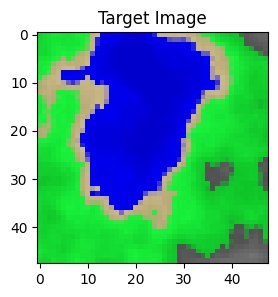

In [56]:
ind = 0
print(train_out[ind])
try:
  print(train_model_outs[ind])
except:
  pass
plot_image(train_target, ind)

In [67]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, target, out):
        self.target = target
        self.out = out

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.target[idx], self.out[idx]

In [70]:
class LightningMixFormer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        config = st1_target.make_mixformer_config("medium")
        self.model = st1_target.MixFormer(config)
        self.train_dataset = MyDataset(train_target, train_out)
        self.valid_dataset = MyDataset(valid_target, valid_out)

    def forward(self, target):
        return self.model(target)

    def get_loss(self, out_pred, out):
        loss = torch.nn.functional.mse_loss(out_pred, out)
        return loss

    def training_step(self, batch, batch_idx):
        target, out = batch
        out_pred = self.model(target)
        loss = self.get_loss(out_pred, out)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        target, out = batch
        out_pred = self.model(target)
        loss = self.get_loss(out_pred, out)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-3, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            }
        }

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=512, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.valid_dataset, batch_size=1024, shuffle=False, num_workers=2)

In [84]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='my_model/',
    filename='model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=10,
    mode='min',
)
csv_logger = pl_loggers.CSVLogger('logs')

In [85]:
model = LightningMixFormer()
trainer = pl.Trainer(
    max_epochs=5,
    callbacks=[checkpoint_callback],
    logger=csv_logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [86]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | model | MixFormer | 509 K 
------------------------------------
471 K     Trainable params
38.0 K    Non-trainable params
509 K     Total params
2.039     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [87]:
import shutil

model_v = 5

source_path = '/content/logs/lightning_logs/version_0/metrics.csv'
dest_path = os.path.join(data_prefix, f'models/logs_medium_v{model_v}.csv')
shutil.copyfile(source_path, dest_path)

trainer.save_checkpoint("model.ckpt")
model_checkpoint_path = os.path.join(data_prefix, f'models/model_medium_v{model_v}.ckpt')
trainer.save_checkpoint(model_checkpoint_path)

In [30]:
checkpoint_path = os.path.join(data_prefix, f'models/model_medium_v{model_v}.ckpt')
model = LightningMixFormer.load_from_checkpoint(checkpoint_path=checkpoint_path)
model.eval()
model.to('cuda')
pass

In [31]:
def get_outputs(targets, outs):
  dataset = MyDataset(targets, outs)
  data_loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False, num_workers=2)
  all_outputs = []
  with torch.no_grad():
      for batch in data_loader:
          target = batch[0].to('cuda')
          outputs = model(target)
          all_outputs.append(outputs.cpu())
  all_outputs = torch.cat(all_outputs, dim=0)
  return all_outputs

train_model_outs = get_outputs(train_target, train_out)
valid_model_outs = get_outputs(valid_target, valid_out)
print(train_model_outs.shape)
print(valid_model_outs.shape)

torch.Size([100000, 5])
torch.Size([10000, 5])


In [32]:
def get_average_score(out):
  avg_values = out.mean(dim=0)
  out_avg = avg_values.repeat(out.shape[0], 1)
  loss = torch.nn.functional.mse_loss(out_avg, out)
  return loss # default loss is about 0.01

print(f'Validation average score = {get_average_score(valid_out)}')
print(f'Train average score = {get_average_score(train_out)}')

Validation average score = 0.009918659925460815
Train average score = 0.009879114106297493


In [47]:
def compare_by_result(out, out2, ind):
  print(f"{out[ind,0]:.4f} {out[ind,1]:.4f} {out[ind,2]:.4f} {out[ind,3]:.4f} {out[ind,4]:.4f}")
  print(f"{out2[ind,0]:.4f} {out2[ind,1]:.4f} {out2[ind,2]:.4f} {out2[ind,3]:.4f} {out2[ind,4]:.4f}")
  print()

compare_by_result(train_out, train_model_outs, 0)
compare_by_result(train_out, train_model_outs, 1)
compare_by_result(train_out, train_model_outs, 2)


0.3096 0.1337 0.4954 0.0613 0.0000
0.3120 0.1349 0.4901 0.0731 0.0006

0.1718 0.2155 0.5226 0.0900 0.0000
0.1650 0.1967 0.5257 0.1114 0.0054

0.0210 0.0773 0.3881 0.3196 0.1940
0.0260 0.0877 0.3836 0.3207 0.1818



In [83]:
import shutil

if True:
  try:
    shutil.rmtree("/content/logs")
  except:
    pass
  try:
    shutil.rmtree("/content/my_model")
  except:
    pass